In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-tweets/tweets.csv


In [16]:
data_dir='/kaggle/input/disaster-tweets/'
df = pd.read_csv(data_dir+'tweets.csv')
df.head(2)

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1


In [17]:
print (f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns" )

The dataset has 11370 rows and 5 columns


In [18]:
print (f"Columns in the data set: {df.columns.values}")

Columns in the data set: ['id' 'keyword' 'location' 'text' 'target']


In [19]:
print (f"There are   are {len(df.keyword.unique())} unique keywords.")

There are   are 219 unique keywords.


In [20]:
print (f"The unique keywords are \n: {df.keyword.unique()}")

The unique keywords are 
: ['ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'bush%20fires' 'casualties' 'casualty' 'catastrophe' 'catastrophic'
 'chemical%20emergency' 'cliff%20fall' 'collapse' 'collapsed' 'collide'
 'collided' 'collision' 'crash' 'crashed' 'crush' 'crushed' 'curfew'
 'cyclone' 'damage' 'danger' 'dead' 'death' 'deaths' 'debris' 'deluge'
 'deluged' 'demolish' 'demolished' 'demolition' 'derail' 'derailed'
 'derailment' 'desolate' 'desolation' 'destroy' 'destroyed' 'destruction'
 'detonate' 'devastated' 'devastation' 'disaster' 'displaced' 'drought'
 'drown' 

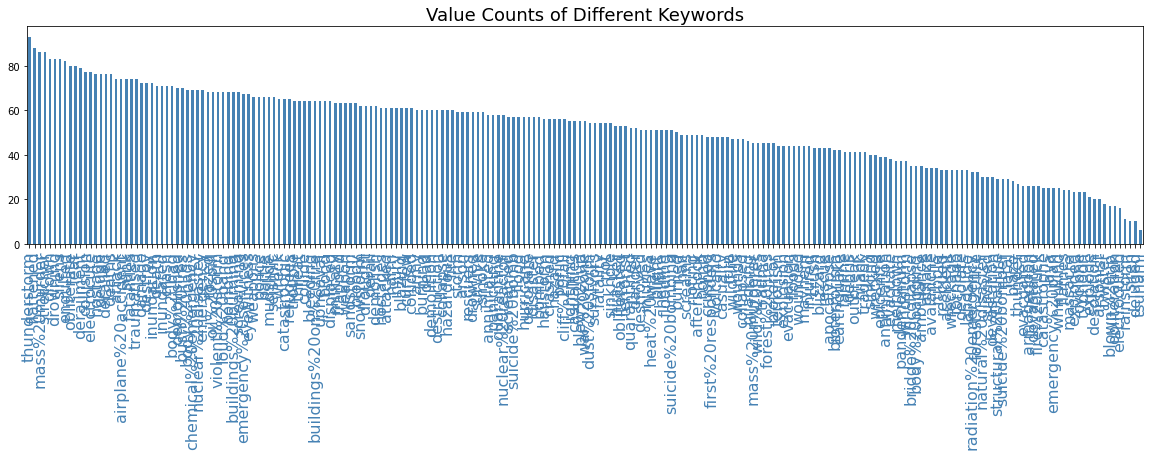

In [21]:
import pylab as plt
df.keyword.value_counts().plot(kind='bar', color='steelblue', figsize=(20, 4))
plt.title('Value Counts of Different Keywords',fontsize=18)
plt.xticks(fontsize=16, rotation=90, color='steelblue');

That looks a little messy. Let's plot only top 20 keywords.

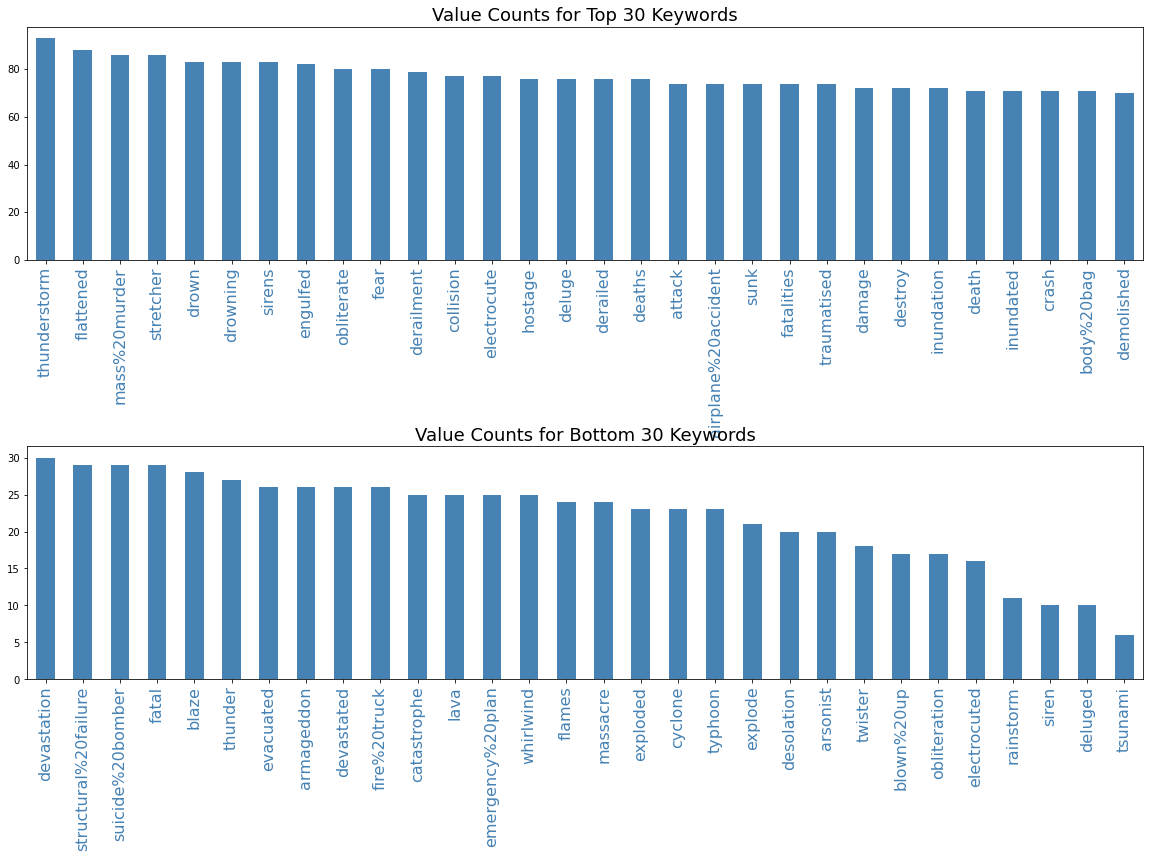

In [22]:
import pylab as plt
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
df.keyword.value_counts()[:30].plot(kind='bar', color='steelblue')#, figsize=(20, 10))
plt.title('Value Counts for Top 30 Keywords',fontsize=18)
plt.xticks(fontsize=16, rotation=90, color='steelblue');
plt.subplots_adjust(hspace=0.8)

plt.subplot(2,1,2)
df.keyword.value_counts()[-30:].plot(kind='bar', color='steelblue')#, figsize=(20, 10))
plt.title('Value Counts for Bottom 30 Keywords',fontsize=18)
plt.xticks(fontsize=16, rotation=90, color='steelblue');
plt.subplots_adjust(wspace=0.5)

It makes sense that there are the least number of tweets for tsunami as it not that frequently occuring disaster.

## Quick look at some of the tweets

In [23]:
print ( df['text'][0], '\n\n', df['text'][123])

Communal violence in Bhainsa, Telangana. "Stones were pelted on Muslims' houses and some houses and vehicles were set ablaze… 

 So Iranian radars cannot tell the difference between an incoming missile and an out going Ukrainian airplane? What… https://t.co/hoeEJEUIHE


### Some tweets that are actually disaster tweets

In [24]:
df[df['target']==1]['text'].values[123]

'मुस्लिम महिला छात्रों से गुंडागर्दी/POLICE ATTACK ON WOMEN STUDENT https://t.co/RKIDl9ohGA via'

### Some tweets that are not disaster tweets

In [25]:
df[df['target']==0]['text'].values[123]

'Iranian military admitted it shot down Ukrainian airplane by missiles accidentally. It is not an accident! It is a crim…'

## Preprocessing the text

### remove the unnecessary part from the text

In [26]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ',text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwors from text
    return text

df['text_processed']=df['text'].apply(lambda x:preprocess_text(x))

In [28]:
df.sample(2)

,id,keyword,location,text,target,text_processed
5378,5378,fatalities,Africa,Police: 60% motorcycle accident fatalities due...,0,police 60 motorcycle accident fatalities due h...
7585,7585,mudslide,"South Carolina, USA","Joe Rogan Goes On Carnivore Diet, Suffers Expl...",0,joe rogan goes carnivore diet suffers explosiv...


### Data splitting and Vectorizing
let's split the data into 60% training set, 20 % validation set and 20 % test set. and then vectorize the data using 

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def split_vectorize_text(df, vec_method='tfidf'):
    
    # Fun Fact: 8848 is the height of Mt Everest (Nepal) in meters.
    df_train_val, df_test  = train_test_split(df, test_size=0.2, random_state = 8848) 
    df_train    , df_valid = train_test_split(df_train_val, test_size=0.25, random_state = 8848)

    if vec_method=='tfidf':
        vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.95)
    elif vec_method=='count':
        vectorizer = CountVectorizer(max_df=0.95)
        
    x_field = 'text_processed'
    y_field = 'target'    
    
    X_train = vectorizer.fit_transform(df_train[x_field])
    X_valid = vectorizer.transform(df_valid[x_field])
    X_test = vectorizer.transform(df_test[x_field])
    
    y_train = df_train[y_field]
    y_valid = df_valid[y_field]
    y_test  = df_test[y_field]
    
    return (X_train, y_train, X_valid, y_valid, X_test, y_test, vectorizer)

(X_train, y_train, X_valid, y_valid, X_test, y_test, vectorizer) = split_vectorize_text(df)


# Model and training the data

In [84]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier 

from sklearn.metrics import accuracy_score, f1_score 

(X_train, y_train, X_valid, y_valid, X_test, y_test, vectorizer) = split_vectorize_text(df)
    
def train_model(X_train, y_train, method='logistic_regression'):
    if method =='logistic_regression':
        log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=8848,max_iter=100)
        model   = log_reg.fit(X_train, y_train)

    elif method =='ridge_classifier':
        clf = RidgeClassifier(solver='auto',random_state=8848, max_iter=100)
        model   = clf.fit(X_train, y_train)

    elif method =='random_forest':        
        clf = RandomForestClassifier(max_depth=5, random_state=8848)        
        model   = clf.fit(X_train, y_train)

    return model

def calc_accuracy(model, X, y):
    preds   = model.predict(X)
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average='macro')
    return (100*np.round(acc, 2), 100*np.round(f1, 2) )

In [90]:
#methods = [LogisticRegression, RidgeClassifier]
results = []
methods = ['logistic_regression', 'ridge_classifier', 'random_forest']
for method in methods:
    model = train_model(X_train, y_train, method=method) 
    acc_train, f1_train= calc_accuracy(model, X_train, y_train)
    acc_valid, f1_valid= calc_accuracy(model, X_valid, y_valid)
    print (f" Method: {method}, \n Training data: accuracy: {acc_train}% and f1_score: {f1_train}% \n \
Validation data: accuracy:  {acc_valid}%  and f1_score: {f1_valid}% \n ")
    results.append( [method, acc_train, acc_valid, f1_train, f1_valid ] )

[LibLinear] Method: logistic_regression, 
 Training data: accuracy: 89.0% and f1_score: 76.0% 
 Validation data: accuracy:  88.0%  and f1_score: 73.0% 
 
 Method: ridge_classifier, 
 Training data: accuracy: 94.0% and f1_score: 88.0% 
 Validation data: accuracy:  89.0%  and f1_score: 78.0% 
 
 Method: random_forest, 
 Training data: accuracy: 81.0% and f1_score: 46.0% 
 Validation data: accuracy:  82.0%  and f1_score: 45.0% 
 


In [91]:
df_results = pd.DataFrame(data=results, columns=['method',
                                                 'Training Accuracy', 'Validation Accuracy', 
                                                 'F1 score (Train)', 'F1 score (Validation)'])
df_results.set_index('method')

,Training Accuracy,Validation Accuracy,F1 score (Train),F1 score (Validation)
method,,,,
logistic_regression,89.0,88.0,76.0,73.0
ridge_classifier,94.0,89.0,88.0,78.0
random_forest,81.0,82.0,46.0,45.0


### Play with the different vectorizer

In [96]:
results = []

for vm in ['tfidf', 'count']:
    (X_train, y_train, X_valid, y_valid, X_test, y_test, vectorizer) = split_vectorize_text(df, vec_method=vm)
    for method in ['logistic_regression', 'ridge_classifier', 'random_forest']:
        model = train_model(X_train, y_train, method=method) 
        acc_train, f1_train= calc_accuracy(model, X_train, y_train)
        acc_valid, f1_valid= calc_accuracy(model, X_valid, y_valid)
        print (f" Vectorizer: {vm}, Method: {method}, \n Training data: accuracy: {acc_train}% and f1_score: {f1_train}% \n \
    Validation data: accuracy:  {acc_valid}%  and f1_score: {f1_valid}% \n ")
        results.append( [method, vm, acc_train, acc_valid, f1_train, f1_valid ] )
    
    

[LibLinear] Vectorizer: tfidf, Method: logistic_regression, 
 Training data: accuracy: 85.0% and f1_score: 64.0% 
     Validation data: accuracy:  86.0%  and f1_score: 66.0% 
 
 Vectorizer: tfidf, Method: ridge_classifier, 
 Training data: accuracy: 100.0% and f1_score: 99.0% 
     Validation data: accuracy:  91.0%  and f1_score: 82.0% 
 
 Vectorizer: tfidf, Method: random_forest, 
 Training data: accuracy: 81.0% and f1_score: 45.0% 
     Validation data: accuracy:  82.0%  and f1_score: 45.0% 
 
[LibLinear] Vectorizer: count, Method: logistic_regression, 
 Training data: accuracy: 98.0% and f1_score: 97.0% 
     Validation data: accuracy:  90.0%  and f1_score: 81.0% 
 
 Vectorizer: count, Method: ridge_classifier, 
 Training data: accuracy: 100.0% and f1_score: 100.0% 
     Validation data: accuracy:  89.0%  and f1_score: 79.0% 
 
 Vectorizer: count, Method: random_forest, 
 Training data: accuracy: 81.0% and f1_score: 45.0% 
     Validation data: accuracy:  82.0%  and f1_score: 45.0% 

In [97]:
df_results = pd.DataFrame(data=results, columns=['method', 'vectorizer',
                                                 'Training Accuracy', 'Validation Accuracy', 
                                                 'F1 score (Train)', 'F1 score (Validation)'])
df_results.set_index('method')

ValueError: 5 columns passed, passed data had 6 columns